# Task 2: Hyperelasticity



In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


### Data import

In [2]:
import numpy as np

import tensorflow as tf

def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)

    batch_size = tf.shape(F)[0]
    

    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
 
    I1 = tf.linalg.trace(C)  
    
  
    C_square = tf.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - tf.linalg.trace(C_square))  
    
   
    J = tf.linalg.det(F)  
    

    Gti = tf.constant([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ], dtype=tf.float32)
    

    Gti = tf.tile(Gti[None, :, :], [batch_size, 1, 1])
 
    I4 = tf.linalg.trace(tf.einsum('bij,bjk->bik', C, Gti))  
    

    I3 = tf.linalg.det(C)


    Cof_C = I3[:, None, None] * tf.linalg.inv(C)


    I5 = tf.linalg.trace(tf.einsum('bij,bjk->bik', Cof_C, Gti)) 
    
    return I1, J, I4, I5

In [3]:
data_biaxial = np.loadtxt('../../calibration/biaxial.txt')
data_pure_shear = np.loadtxt('../../calibration/pure_shear.txt')
data_uniaxial = np.loadtxt('../../calibration/uniaxial.txt')


def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    W = data[:, 18] 
    return F, P, W


F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_pure_shear, P_pure_shear, W_pure_shear = process_data(data_pure_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

In [4]:

I1_data_biaxial,J_data_biaxial,I4_data_biaxial,I5_data_biaxial = compute_invariants(F_biaxial) 
I1_data_pure_shear,J_data_pure_shear,I4_data_pure_shear,I5_data_pure_shear = compute_invariants(F_pure_shear)
I1_data_uniaxial,J_data_uniaxial,I4_data_uniaxial,I5_data_uniaxial = compute_invariants(F_uniaxial)

In [5]:
data_biaxial_test = np.loadtxt('../../test/biax_test.txt')
data_mixed_test = np.loadtxt('../../test/mixed_test.txt')

F_mixed_test, P_mixed_test, W_mixed_test = process_data(data_mixed_test)
F_biaxial_test, P_biaxial_test, W_biaxial_test = process_data(data_biaxial_test)
I1_data_biaxial_test,J_data_biaxial_test,I4_data_biaxial_test,I5_data_biaxial_test = compute_invariants(F_biaxial_test)
I1_data_mixed_test,J_data_mixed_test,I4_data_mixed_test,I5_data_mixed_test = compute_invariants(F_mixed_test)

In [6]:
import numpy as np


I_train_biaxial = np.column_stack((I1_data_biaxial, J_data_biaxial, -J_data_biaxial, I4_data_biaxial, I5_data_biaxial))
I_train_pure_shear = np.column_stack((I1_data_pure_shear, J_data_pure_shear, -J_data_pure_shear, I4_data_pure_shear, I5_data_pure_shear))
I_train_uniaxial = np.column_stack((I1_data_uniaxial, J_data_uniaxial, -J_data_uniaxial, I4_data_uniaxial, I5_data_uniaxial))

I_train = np.concatenate([I_train_biaxial, I_train_pure_shear, I_train_uniaxial], axis=0)


I_test_biaxial = np.column_stack((I1_data_biaxial_test, J_data_biaxial_test, -J_data_biaxial_test, I4_data_biaxial_test, I5_data_biaxial_test))
I_test_mixed = np.column_stack((I1_data_mixed_test, J_data_mixed_test, -J_data_mixed_test, I4_data_mixed_test, I5_data_mixed_test))


I_test = np.concatenate([I_test_mixed, I_test_biaxial], axis=0)


In [7]:
W_train = np.concatenate([W_biaxial, W_pure_shear, W_uniaxial], axis=0)

In [8]:
I_train_tensor = tf.convert_to_tensor(I_train, dtype=tf.float32)
W_train_tensor = tf.convert_to_tensor(W_train, dtype=tf.float32)
I_test_tensor = tf.convert_to_tensor(I_test, dtype=tf.float32)

### Load model (only with energy)

In [9]:

import models as lm
importlib.reload(lm)
model1 = lm.main()

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 private_c_to_w (_C_to_W)    (None, 1)                 385       
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
21/21 [==============================] - 0s 1ms/step - loss: 566.6786
Epoch 2/2500
21/21 [==============================] - 0s 1ms/step - loss: 510.4360
Epoch 3/2500
21/21 [==============================] - 0s 1ms/step - loss: 431.9264
Epoch 4/2500
21/21 [==============================] - 0s 1ms/step - loss: 348.9908
Epoch 5/2500
21/21 [==============================] - 0s 1ms/step - loss: 274.9467
Epoch 6/2500
21/21 [==============================] - 0s 1ms/step - loss: 248.3168
Epoch 7/2500
21/21 [==============================] - 0s 1ms/step - loss: 238.3726
Epoch 8/2500
21/21 [==============================] - 0s 1ms/step - loss: 230.7349
Epoch 9/2500
21/21 [==============================] - 0s 1ms/step - loss: 224.2036
Epoch 10/2500
21/21 [==============================] - 0s 1ms/step - loss: 217.3140
Epoch 11/2500
21/21 [==============================] - 0s 1ms/step - loss: 211.1597
Epoch 12/2500
21/21 [==============================] - 0s 1ms/step - loss: 205.2589
E

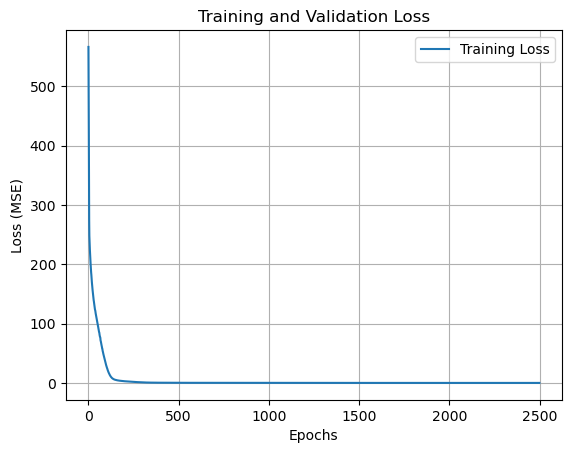

In [10]:


history = model1.fit(I_train_tensor, W_train_tensor, epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [11]:
def compute_stress_tensor(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)

  
    P = tape.gradient(W_pred, F)
    
 
    #print("P:", P)
    
    return P

In [20]:
P_biaxial_test_pred = compute_stress_tensor(F_biaxial_test,model1)
P_mixed_test_pred = compute_stress_tensor(F_mixed_test, model1)
P_biaxial_pred = compute_stress_tensor(F_biaxial, model1)
P_pure_shear_pred = compute_stress_tensor(F_pure_shear, model1)
P_uniaxial_pred = compute_stress_tensor(F_uniaxial, model1)

C:\Users\10472\AppData\Local\Temp\ipykernel_3520\2702517028.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^',


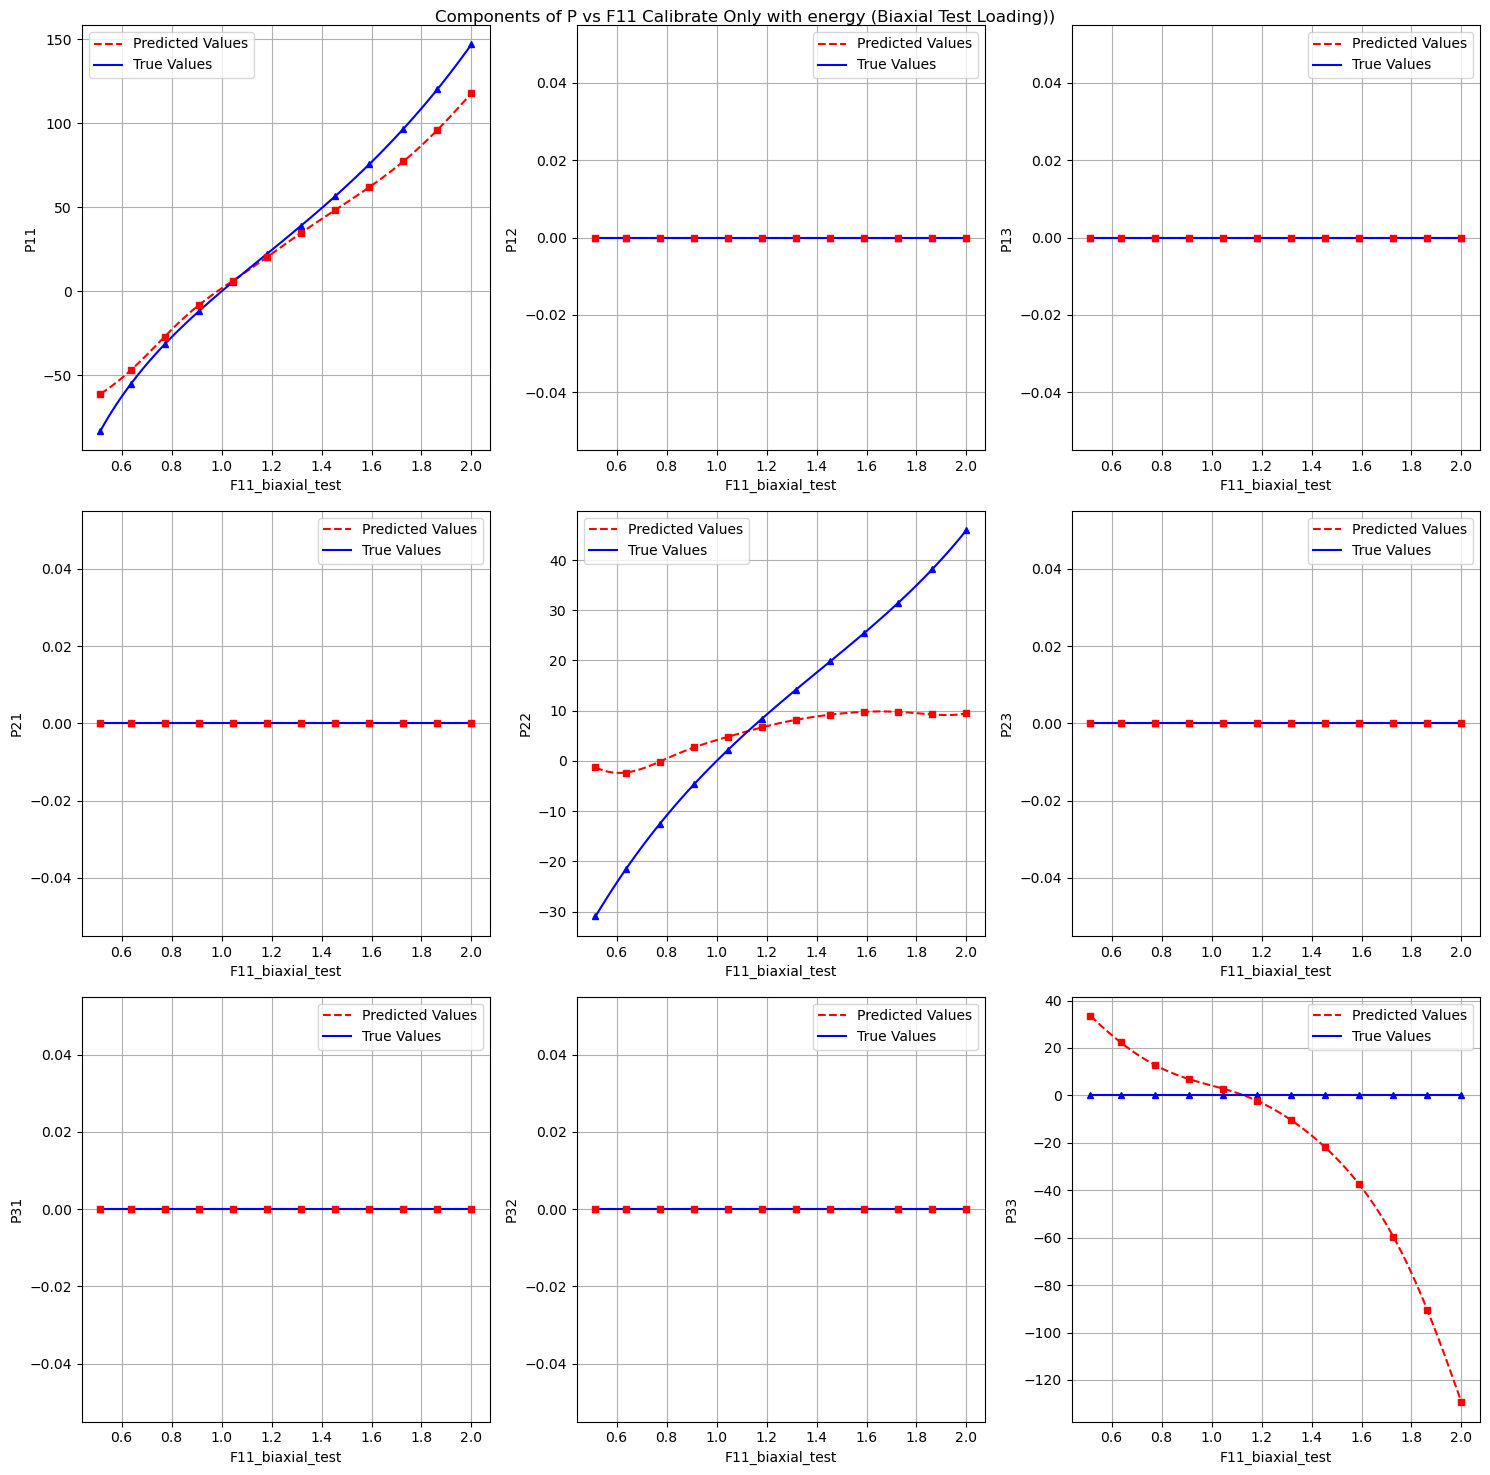

In [18]:
import matplotlib.pyplot as plt
import numpy as np

F11_biaxial_test = F_biaxial_test[:, 0, 0]
P_biaxial_test_pred = P_biaxial_test_pred.numpy()
# Select 12 evenly spaced indices
total_points = len(F11_biaxial_test)
indices = np.linspace(0, total_points-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 Calibrate Only with energy (Biaxial Test Loading))')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_biaxial_test, P_biaxial_test_pred[:, i, j], 'r--', label='Predicted Values')
        # Plot the continuous true values with solid blue line
        axs[index].plot(F11_biaxial_test, P_biaxial_test[:, i, j], 'b-', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test_pred[indices, i, j], 'r', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_biaxial_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


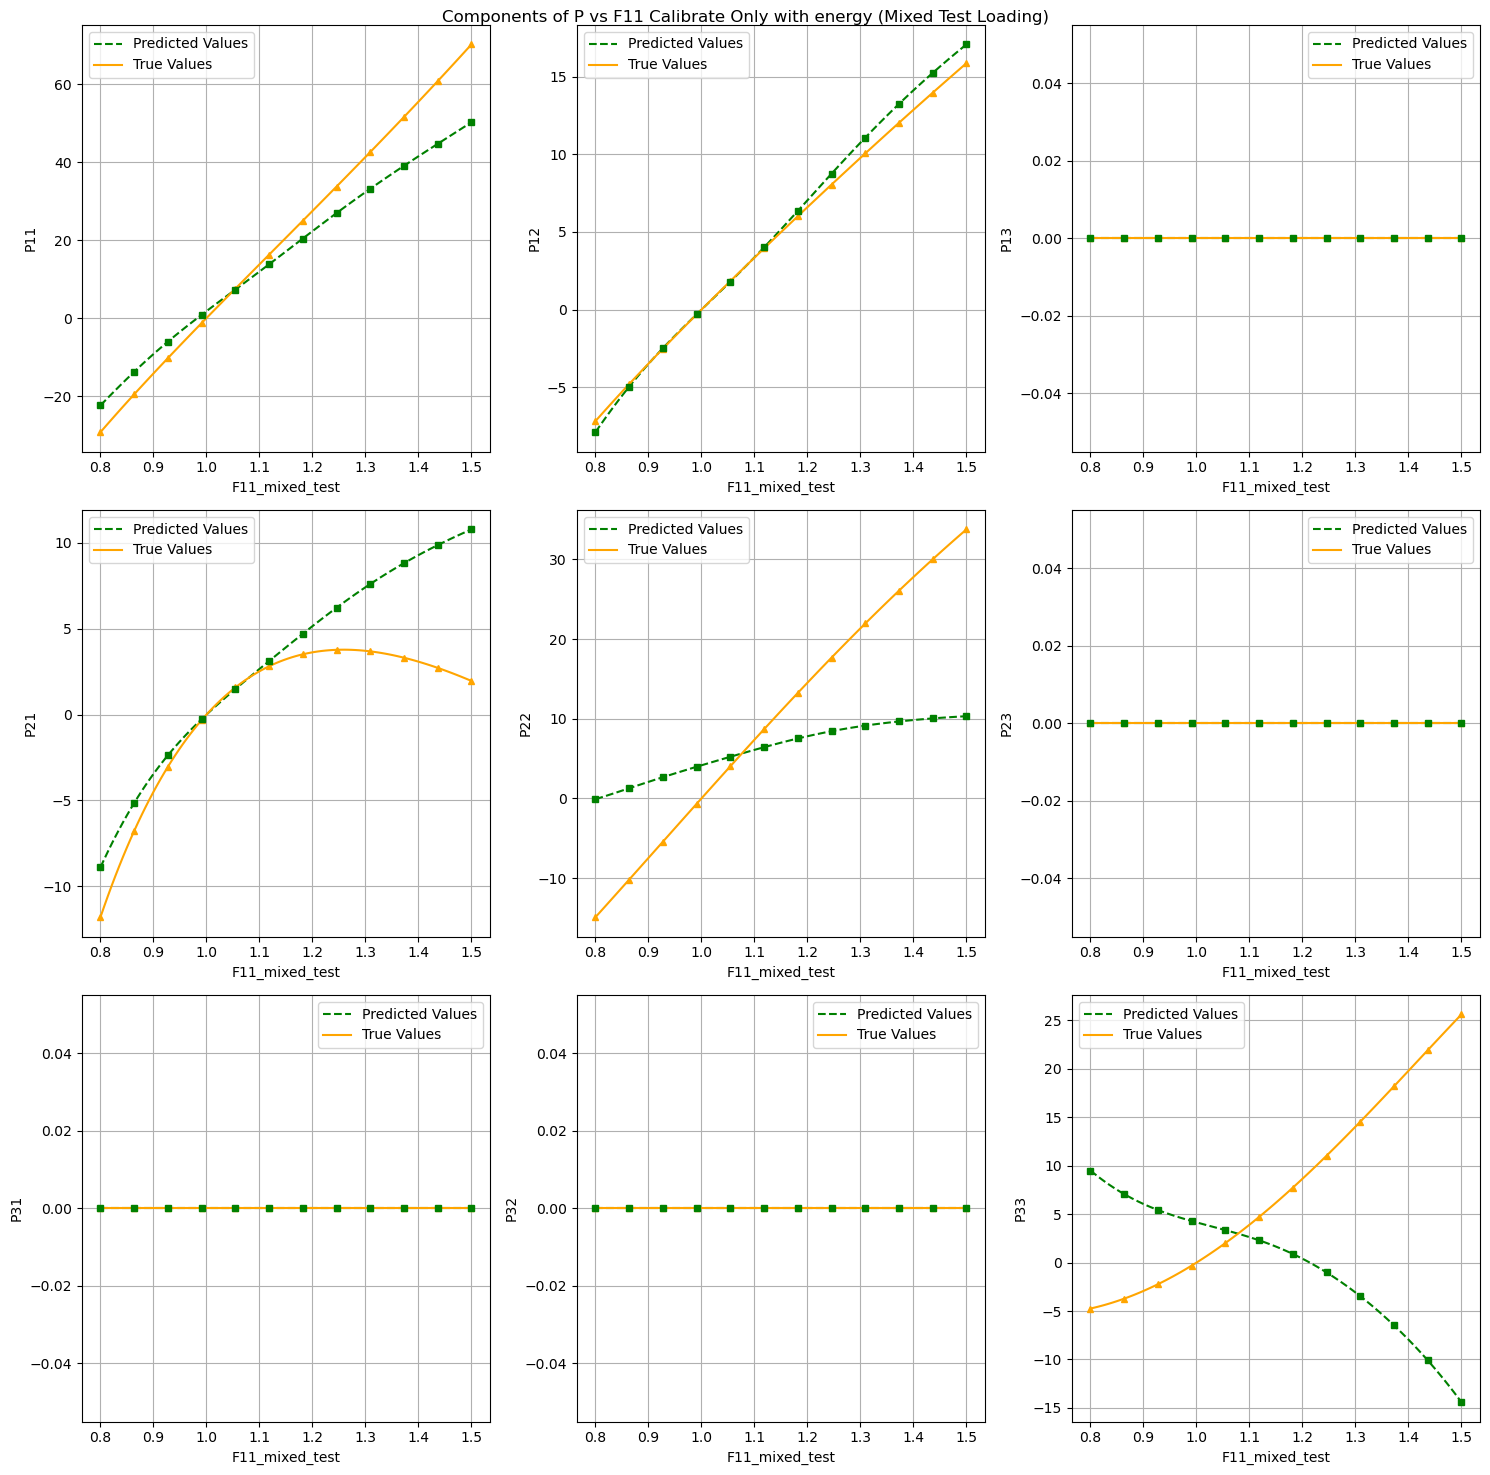

In [21]:
# 假设 F_mixed_test 和 P_mixed_test_pred 已经定义，F_mixed_test 的形状是 (N, 3, 3)

F11_mixed_test = F_mixed_test[:, 0, 0]  # 获取 F11 数据

P_mixed_test_pred = P_mixed_test_pred.numpy()  # 将张量转换为 numpy 数组
P_mixed_test_pred = P_mixed_test_pred.reshape(-1, 3, 3)  # 重新调整为 (N, 3, 3)
P_mixed_test = P_mixed_test.reshape(-1, 3, 3)  # 已知的真实值

# Select 12 evenly spaced indices
total_points_mixed = len(F11_mixed_test)
indices_mixed = np.linspace(0, total_points_mixed-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 Calibrate Only with energy (Mixed Test Loading)')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_mixed_test, P_mixed_test_pred[:, i, j], 'g--', label='Predicted Values')
        # Plot the continuous true values with solid orange line
        axs[index].plot(F11_mixed_test, P_mixed_test[:, i, j], 'orange', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test[indices_mixed, i, j], 'orange', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test_pred[indices_mixed, i, j], 'g', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_mixed_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


### Calibrate the model with both

In [22]:
model2 = model1
optimizer = tf.optimizers.Adam(learning_rate=0.001)


def train_step(F, P_true, model):
    with tf.GradientTape(persistent=True) as tape:  
        tape.watch(F)
        
        
        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)
        
        
        P_pred = tape.gradient(W_pred, F)
        
        
        loss_P = tf.reduce_mean(tf.square(P_pred - P_true))  
        loss = loss_P
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [23]:
F_train = np.concatenate([F_biaxial, F_pure_shear, F_uniaxial], axis=0)
F_train_tensor = tf.convert_to_tensor(F_train, dtype=tf.float32)
P_biaxial
P_train = np.concatenate([P_biaxial, P_pure_shear, P_uniaxial], axis=0)
P_train_tensor = tf.convert_to_tensor(P_train, dtype=tf.float32)

In [24]:
for epoch in range(2500):
   
    loss = train_step(F_train_tensor, P_train_tensor, model2)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 234.90328979492188
Epoch 2, Loss: 230.64344787597656
Epoch 3, Loss: 226.538330078125
Epoch 4, Loss: 222.58749389648438
Epoch 5, Loss: 218.7645721435547
Epoch 6, Loss: 215.06895446777344
Epoch 7, Loss: 211.49974060058594
Epoch 8, Loss: 208.05604553222656
Epoch 9, Loss: 204.73654174804688
Epoch 10, Loss: 201.53965759277344
Epoch 11, Loss: 198.46347045898438
Epoch 12, Loss: 195.5057373046875
Epoch 13, Loss: 192.66392517089844
Epoch 14, Loss: 189.93527221679688
Epoch 15, Loss: 187.3166961669922
Epoch 16, Loss: 184.8050994873047
Epoch 17, Loss: 182.39720153808594
Epoch 18, Loss: 180.08956909179688
Epoch 19, Loss: 177.8787078857422
Epoch 20, Loss: 175.7610626220703
Epoch 21, Loss: 173.7330322265625
Epoch 22, Loss: 171.79092407226562
Epoch 23, Loss: 169.9310760498047
Epoch 24, Loss: 168.14974975585938
Epoch 25, Loss: 166.44326782226562
Epoch 26, Loss: 164.80789184570312
Epoch 27, Loss: 163.23997497558594
Epoch 28, Loss: 161.73583984375
Epoch 29, Loss: 160.2919158935547
Epoch 30

In [25]:
P_biaxial_test_pred = compute_stress_tensor(F_biaxial_test,model2)
P_mixed_test_pred = compute_stress_tensor(F_mixed_test, model2)
P_biaxial_pred = compute_stress_tensor(F_biaxial, model2)
P_pure_shear_pred = compute_stress_tensor(F_pure_shear, model2)
P_uniaxial_pred = compute_stress_tensor(F_uniaxial, model2)

C:\Users\10472\AppData\Local\Temp\ipykernel_3520\4019656882.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^',


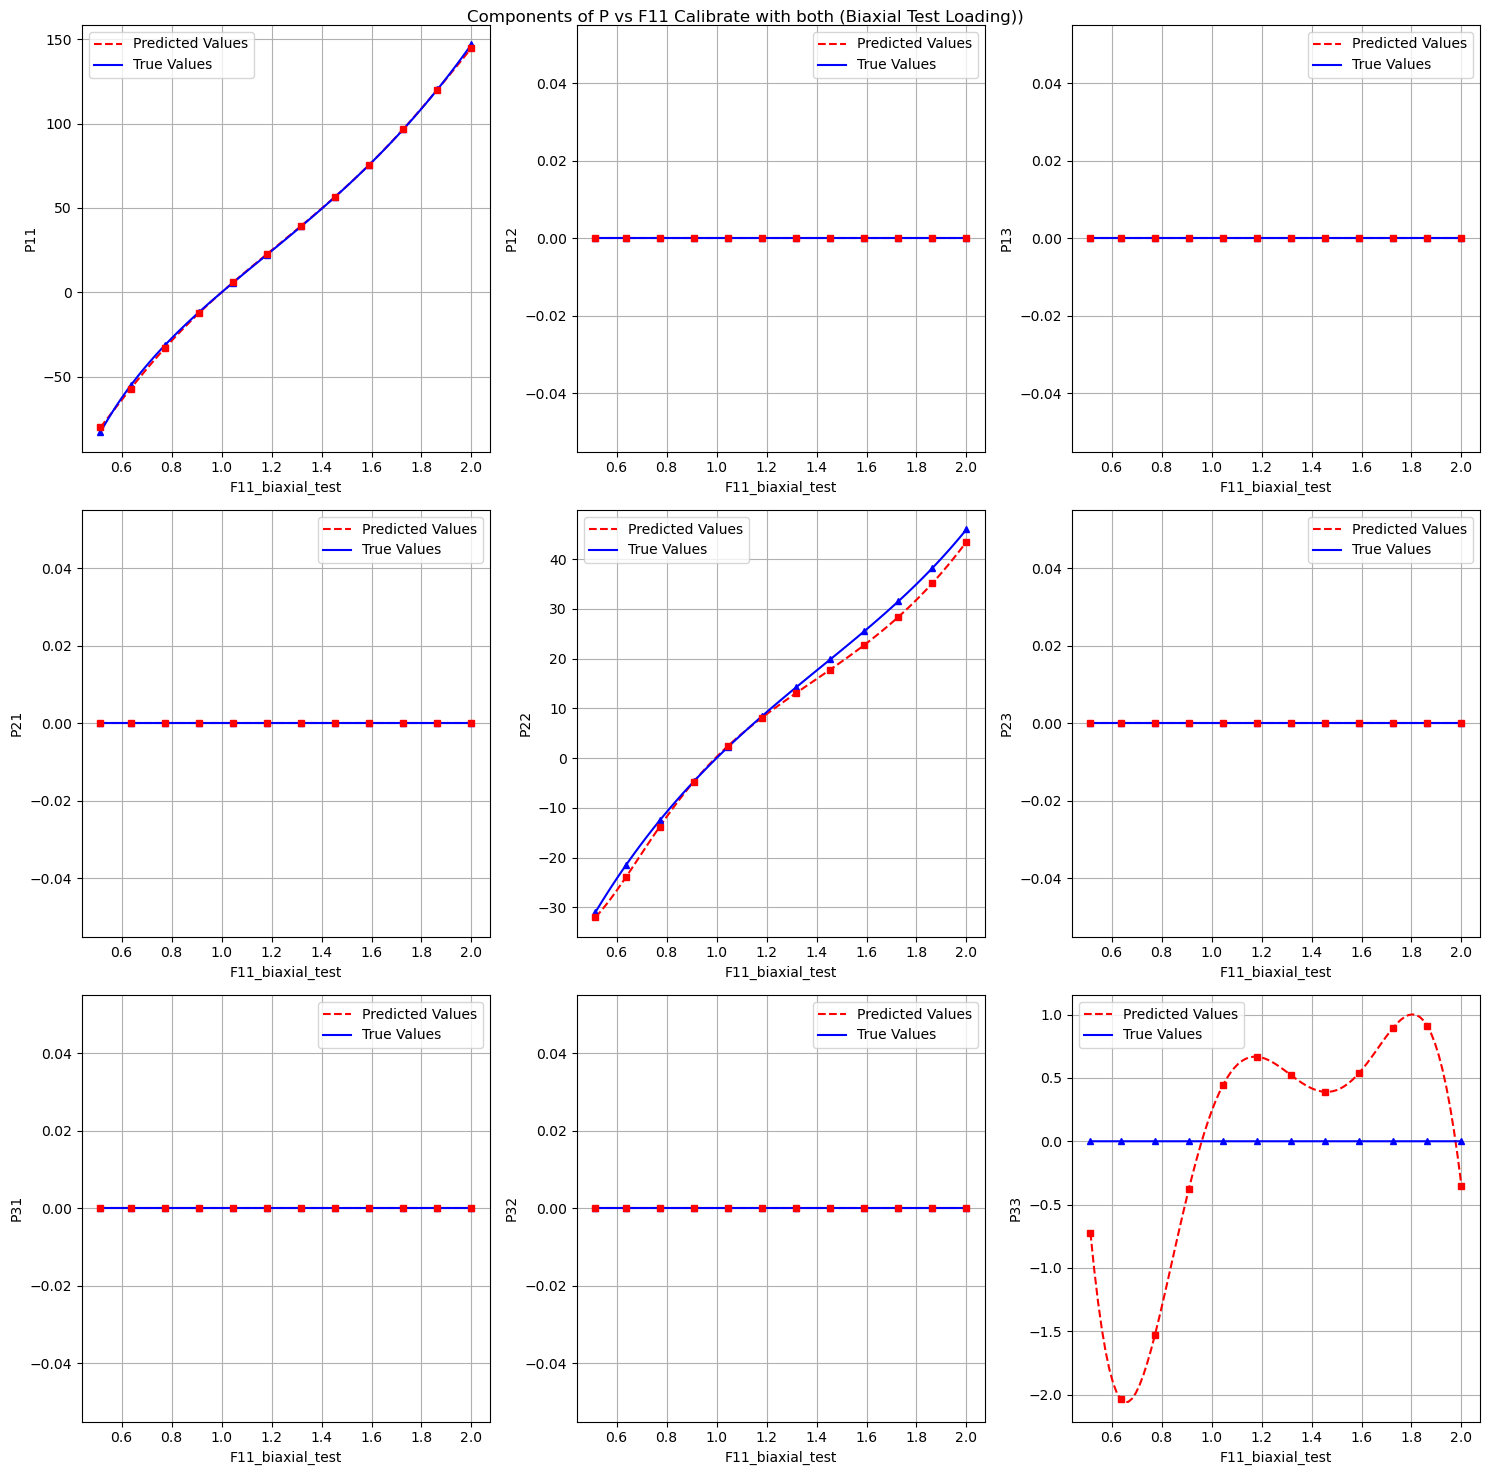

In [26]:
import matplotlib.pyplot as plt
import numpy as np

F11_biaxial_test = F_biaxial_test[:, 0, 0]
P_biaxial_test_pred = P_biaxial_test_pred.numpy()
# Select 12 evenly spaced indices
total_points = len(F11_biaxial_test)
indices = np.linspace(0, total_points-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 Calibrate with both (Biaxial Test Loading))')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_biaxial_test, P_biaxial_test_pred[:, i, j], 'r--', label='Predicted Values')
        # Plot the continuous true values with solid blue line
        axs[index].plot(F11_biaxial_test, P_biaxial_test[:, i, j], 'b-', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test_pred[indices, i, j], 'r', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_biaxial_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


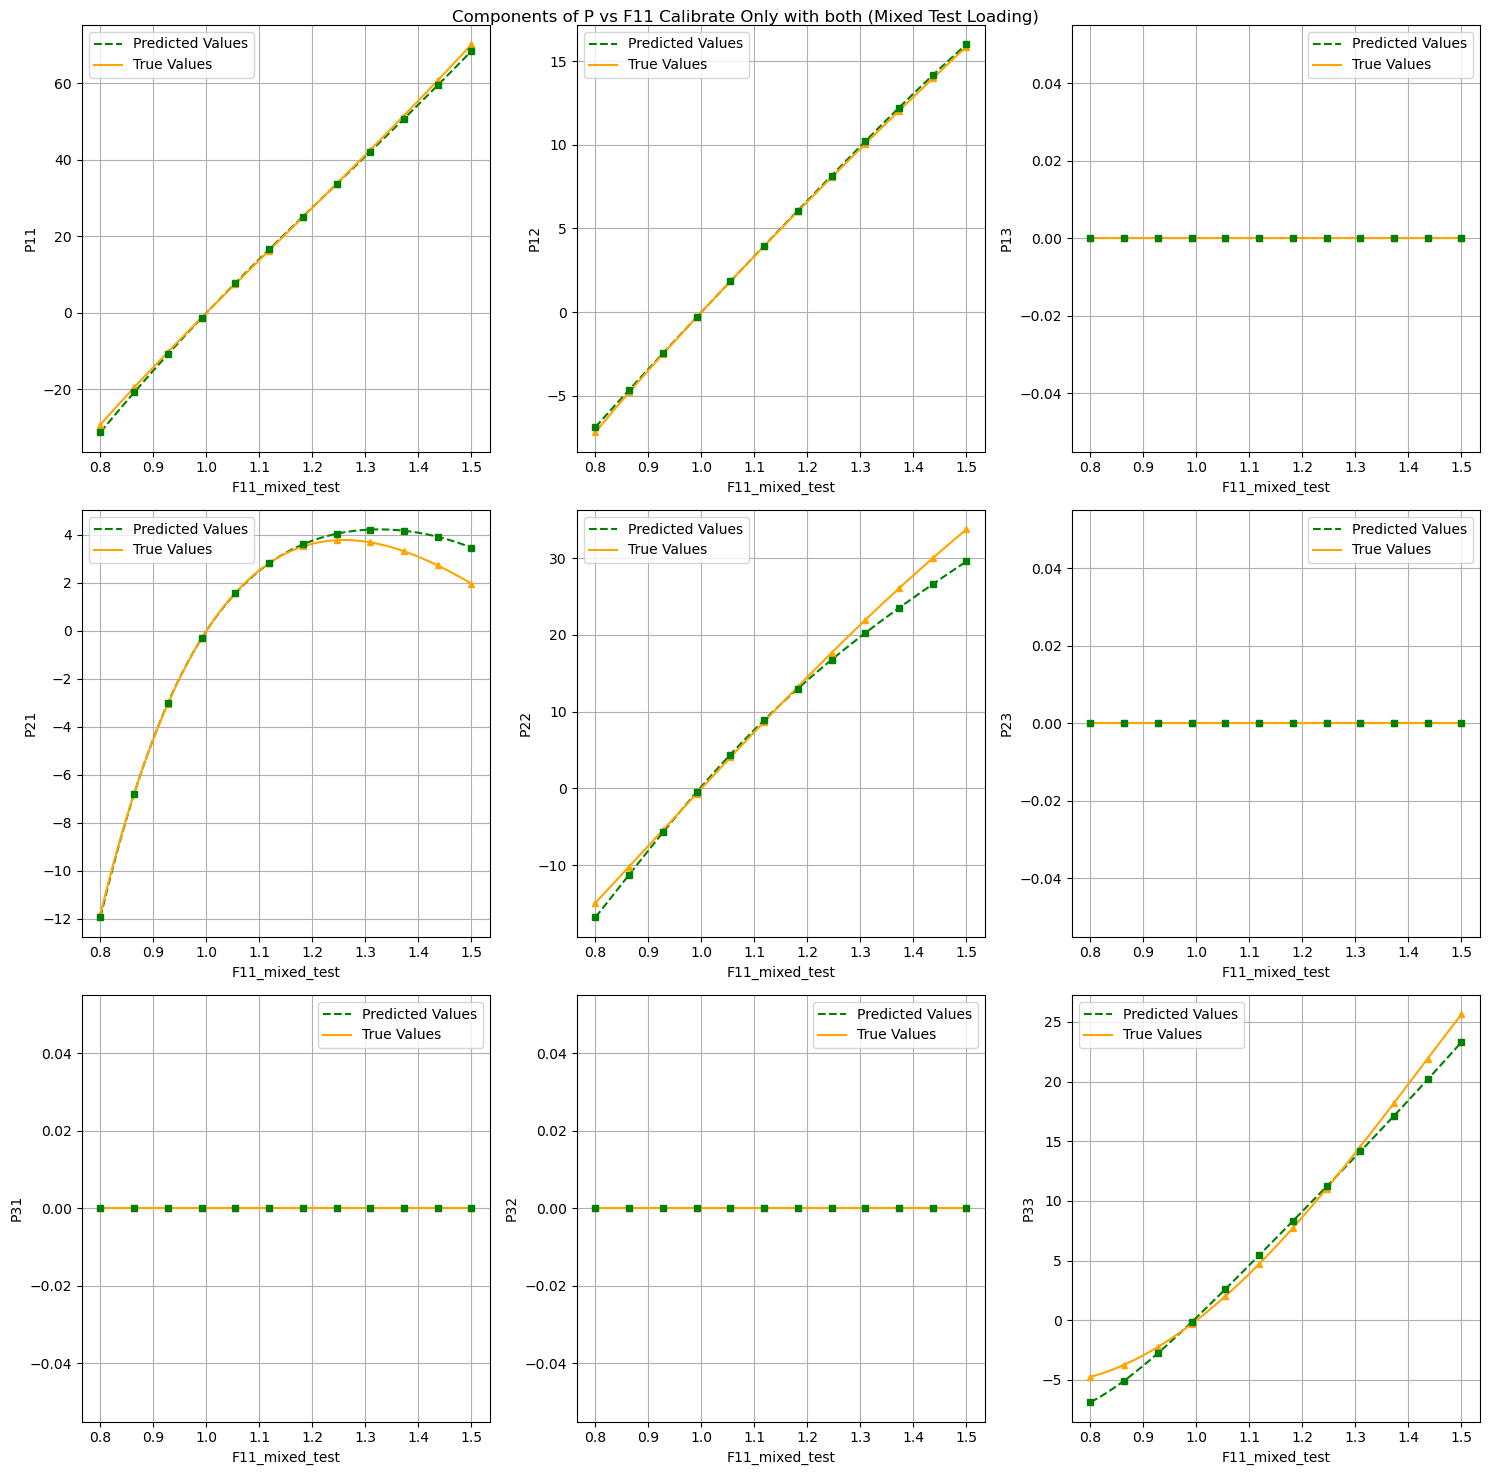

In [ ]:
# 假设 F_mixed_test 和 P_mixed_test_pred 已经定义，F_mixed_test 的形状是 (N, 3, 3)

F11_mixed_test = F_mixed_test[:, 0, 0]  # 获取 F11 数据

P_mixed_test_pred = P_mixed_test_pred.numpy()  # 将张量转换为 numpy 数组
P_mixed_test_pred = P_mixed_test_pred.reshape(-1, 3, 3)  # 重新调整为 (N, 3, 3)
P_mixed_test = P_mixed_test.reshape(-1, 3, 3)  # 已知的真实值

# Select 12 evenly spaced indices
total_points_mixed = len(F11_mixed_test)
indices_mixed = np.linspace(0, total_points_mixed-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 Calibrate with both (Mixed Test Loading)')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_mixed_test, P_mixed_test_pred[:, i, j], 'g--', label='Predicted Values')
        # Plot the continuous true values with solid orange line
        axs[index].plot(F11_mixed_test, P_mixed_test[:, i, j], 'orange', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test[indices_mixed, i, j], 'orange', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test_pred[indices_mixed, i, j], 'g', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_mixed_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


### Calibrate the model only with stress

In [34]:
import models_P as lm_p
importlib.reload(lm_p)
model3 = lm_p.main()

model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 


 private_c_to_p_2 (_C_to_P)  (None, 9)                 521       
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
21/21 [==============================] - 0s 1ms/step - loss: 423.3980
Epoch 2/2500
21/21 [==============================] - 0s 1ms/step - loss: 407.7742
Epoch 3/2500
21/21 [==============================] - 0s 1ms/step - loss: 393.5179
Epoch 4/2500
21/21 [==============================] - 0s 1ms/step - loss: 379.1875
Epoch 5/2500
21/21 [==============================] - 0s 1ms/step - loss: 362.5853
Epoch 6/2500
21/21 [==============================] - 0s 1ms/step - loss: 346.9586
Epoch 7/2500
21/21 [==============================] - 0s 1ms/step - loss: 329.1606
Epoch 8/2500
21/21 [==============================] - 0s 1ms/step - loss: 313.9763
Epoch 9/2500
21/21 [==============================] - 0s 1ms/step - loss: 300.7270
Epoch 10/2500
21/21 [==============================] - 0s 1ms/step - loss: 288.8206
Epoch 11/2500
21/21 [==============================] - 0s 1ms/step - loss: 277.9853
Epoch 12/2500
21/21 [==============================] - 0s 1ms/step - loss: 268.3655
E

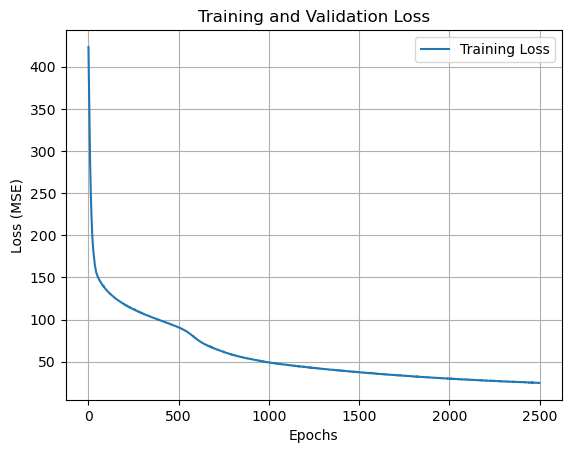

In [36]:
P_train = np.concatenate([P_biaxial.reshape(-1, 9), P_pure_shear.reshape(-1, 9), P_uniaxial.reshape(-1, 9)], axis=0)
P_train_tensor = tf.convert_to_tensor(P_train, dtype=tf.float32)
history = model3.fit(I_train_tensor, P_train_tensor, epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


C:\Users\10472\AppData\Local\Temp\ipykernel_3520\2858629472.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^',


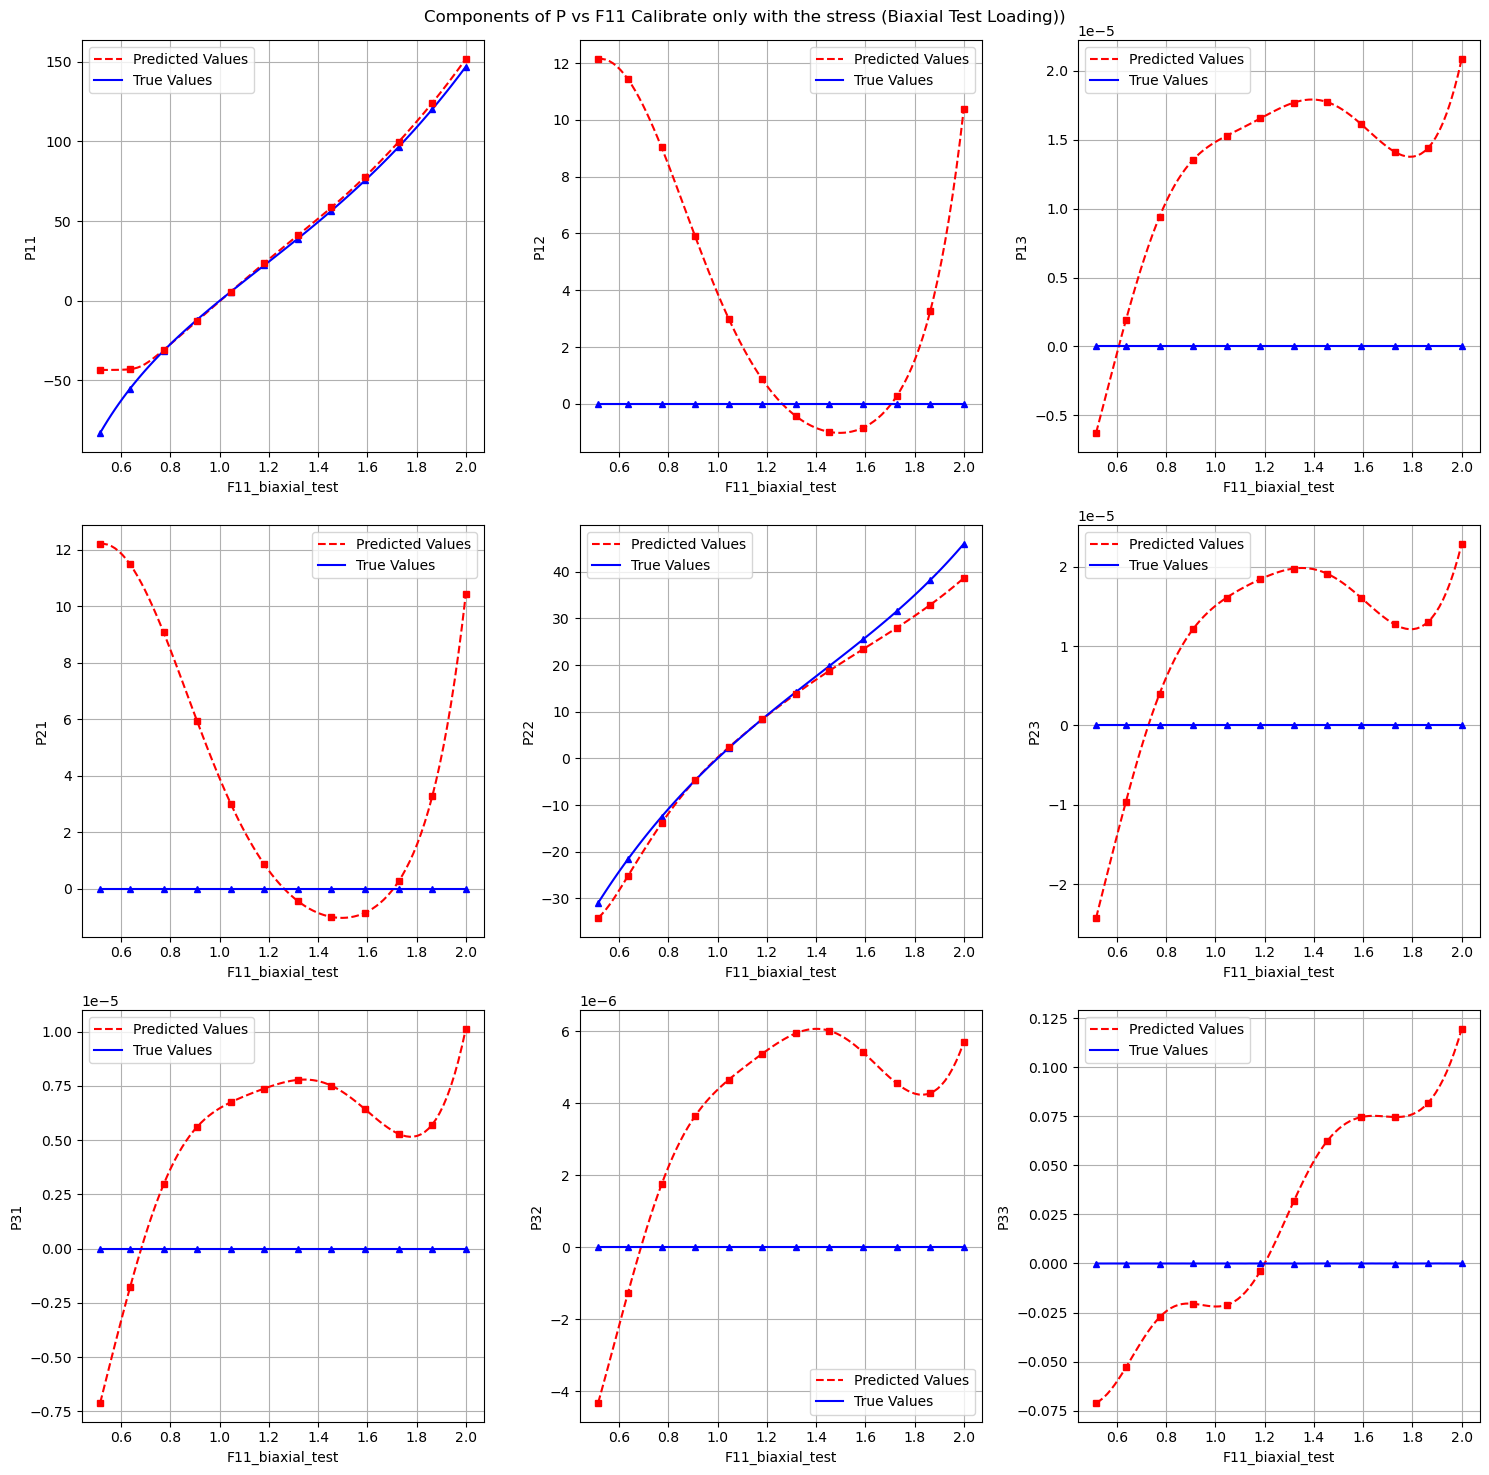

In [38]:
import matplotlib.pyplot as plt
import numpy as np

P_biaxial_test_pred = model3(I_test_biaxial).numpy().reshape(-1, 3, 3)
F11_biaxial_test = F_biaxial_test[:, 0, 0]

# Select 12 evenly spaced indices
total_points = len(F11_biaxial_test)
indices = np.linspace(0, total_points-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 Calibrate only with the stress (Biaxial Test Loading))')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_biaxial_test, P_biaxial_test_pred[:, i, j], 'r--', label='Predicted Values')
        # Plot the continuous true values with solid blue line
        axs[index].plot(F11_biaxial_test, P_biaxial_test[:, i, j], 'b-', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test_pred[indices, i, j], 'r', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_biaxial_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


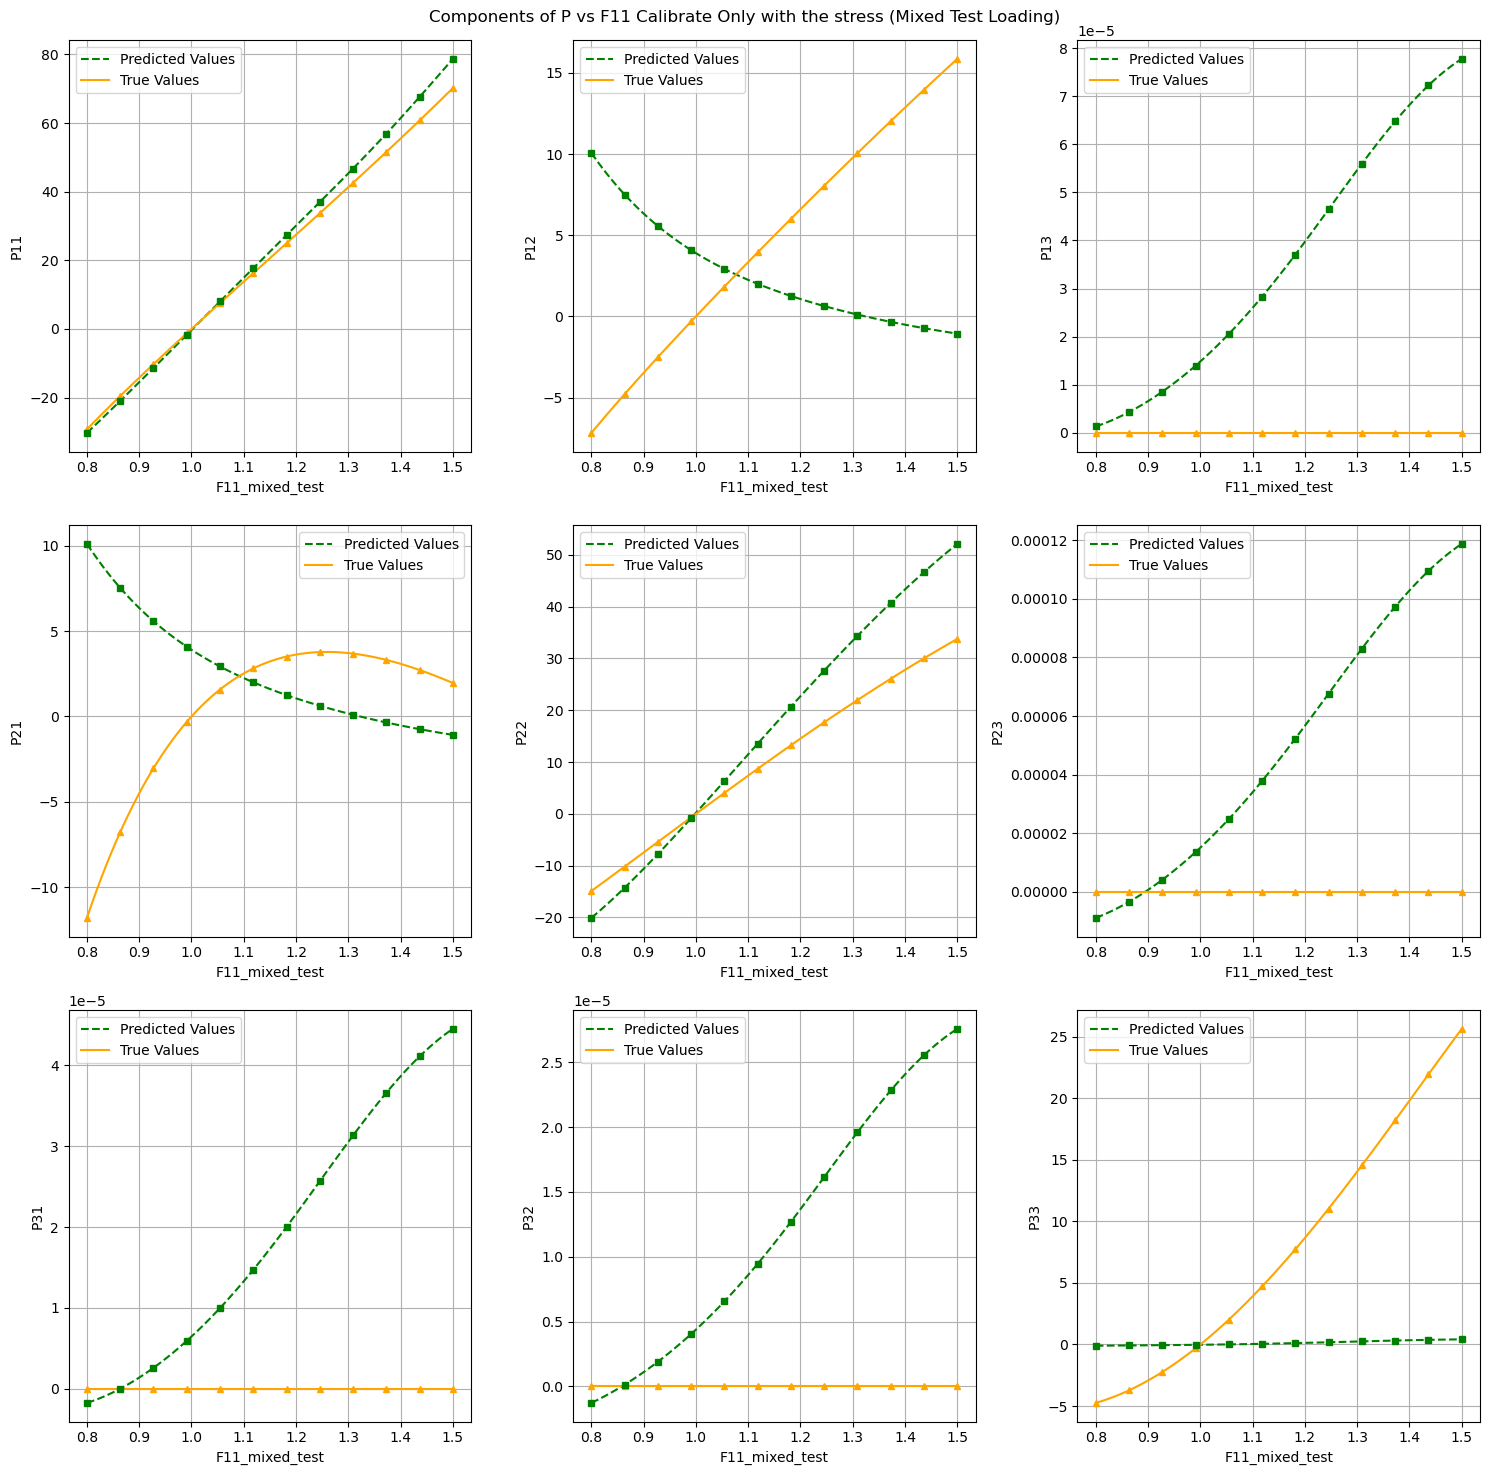

In [40]:
# 假设 F_mixed_test 和 P_mixed_test_pred 已经定义，F_mixed_test 的形状是 (N, 3, 3)

F11_mixed_test = F_mixed_test[:, 0, 0]  # 获取 F11 数据
P_mixed_test_pred = model3(I_test_mixed).numpy().reshape(-1, 3, 3)  # 将张量转换为 numpy 数组
P_mixed_test = P_mixed_test.reshape(-1, 3, 3)  # 已知的真实值

# Select 12 evenly spaced indices
total_points_mixed = len(F11_mixed_test)
indices_mixed = np.linspace(0, total_points_mixed-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 Calibrate Only with the stress (Mixed Test Loading)')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_mixed_test, P_mixed_test_pred[:, i, j], 'g--', label='Predicted Values')
        # Plot the continuous true values with solid orange line
        axs[index].plot(F11_mixed_test, P_mixed_test[:, i, j], 'orange', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test[indices_mixed, i, j], 'orange', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test_pred[indices_mixed, i, j], 'g', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_mixed_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()
